In [140]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import plotly.express as px
from mpl_toolkits import mplot3d 

np.random.seed(11111)

Heat Equation:

\begin{align}
\partial_t u_{\theta}(t,x) &= \partial^2_{xx}u_{\theta}(t,x) \\
u_{\theta}(0,x) &= \varphi(x)
\end{align}

Here time-space is modeled by $(t,x)\in[0,1]^{2}$, thus $u_{\theta}\colon[0,1]^2\to \R$


In [215]:
class HeatModel(tf.Module):
    # Heat equation PINN-solver. 
    def __init__(self, layers_size):

        self.input_dim = layers_size[0]
        self.layers = layers_size
        # List of tf.Tensor objects
        self.W = []

        # Initializer
        init = tf.initializers.GlorotUniform(seed=333)

        for i in range(len(layers_size) - 1):
            input_dim = layers_size[i]
            output_dim = layers_size[i + 1]

            w = tf.Variable(init([output_dim, input_dim], dtype='float64'), trainable=True, name=f'w{i+1}')
            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.learning_rate = 0.01
    
    

    def evaluate(self, x):
        """Evaluates the NN at x.

        Args:
            x : Shape must match the NN input shape.

        Returns:
            tf.Tensor: u_theta(x)
        """
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
    
    def init_condition(self, init_data):
        """Initial condition of the PDE.

        Args:
            init_data: data for t=0.

        Returns:
            float: initial condition.
        """
        return tf.square(init_data[1][0]) * (2 - init_data[1][0])
   
    ##################### LOSS METHODS ###########################

    def initial_condition_loss(self, init_data):
        return tf.subtract(self.evaluate(init_data), self.init_condition(init_data))

    def physics_loss(self, interior_data):

        # Error given by the PDE over data_set.
        # We compute the first and second derivative w.r.t the NN variable.
        # returns tf.Tensor shape=().
        # Every derivative is reshaped to shape (1,1).
        
        z = tf.reshape(tf.Variable(interior_data, trainable=False), (self.input_dim,1))
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                tape1.watch(z)
                u = self.evaluate(z)
            u_z = tape1.gradient(u, z)
            tape2.watch(z)
        u_zz = tape2.gradient(u_z, z)

        u_t = tf.reshape(u_z[0], (1,1))
        u_xx = tf.reshape(u_zz[1], (1,1))

        del tape1, tape2
        
        return tf.subtract(u_t, 4 * u_xx)


    def total_loss(self, init_data, interior_data):
        """Computes the loss at init_data and interior_data.

        Args:
            init_data: shape=(2,1).
            interior_data: shape=(2,1).

        Returns:
            _type_: _description_
        """

        return tf.square(self.initial_condition_loss(init_data) + self.physics_loss(interior_data))

    ##################### TRAINING METHODS ###########################


    def apply_gradients(self, gradients_list: list):
        """Updates the parameters according to SGD iteration.

        Args:
            gradients_list (list): list of tf.Tensor
        """
        for g, p in zip(gradients_list, self.W):
            p.assign_sub(self.learning_rate * g)
    
    
    def train(self, num_iter, num_data):
        #opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

        init_data = [[[0], [x]] for x in np.random.uniform(0,2,num_data)]
        interior_data = [[[t], [x]] for t,x in zip(np.random.uniform(0,2,num_data),np.random.uniform(0,3,num_data))]
        loss = []
        for _ in tqdm(range(num_iter)):
            j = np.random.randint(num_data)
            k = np.random.randint(num_data)
            with tf.GradientTape() as tape:
                tape.watch(self.W)
                target = self.total_loss(init_data[j], interior_data[j])
                #target = self.initial_condition_loss(init_data[j]) ** 2
            grads = tape.gradient(target, self.W)
            self.apply_gradients(grads)
            loss.append(target)
            #opt.apply_gradients(zip(grads, self.W))
        return loss

            

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:10<00:00, 39.88it/s]


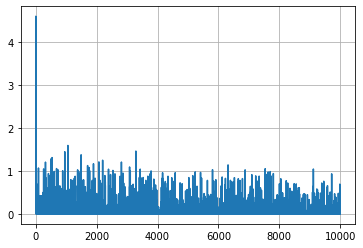

In [216]:
# Create model with input dimension 2 (t,x) and output dimension 1.

model = HeatModel([2,32,32,32,32,32,32,1])
loss = model.train(5000, 1000)
#
values = list(map(lambda v: v[0][0].numpy(), loss))
plt.plot(values)
plt.grid()


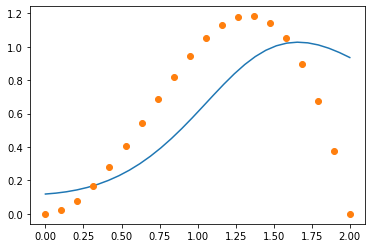

In [223]:
x = np.linspace(0,2,30)
y = [model.evaluate([[0],[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
x = np.linspace(0,2,20)
plt.plot(x, x**2*(2-x), 'o')
